<a href="https://colab.research.google.com/github/giovanni-lucarelli/distribution-shift/blob/main/datasetV03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from data_generation import *

# Dataset Construction

In [20]:
set_seed = 42
np.random.seed(set_seed)

### Parameters of the problem

In [21]:
num_samples = 1000
num_features = 3

# degree of the polinomio for the attribute relationship
degree = 2

## Training Set

In [23]:
# mean_train = [0.31477929, 0.37126453, 0.55909894]

# covariance_train = np.array([[ 0.96256193, -0.03037203,  0.65610891],
# 							 [-0.03037203,  0.52497517,  0.46708607],
# 							 [ 0.65610891,  0.46708607,  1.26146725]])

# random multivariate
mean_train = np.random.rand(num_features)
covariance_train = random_cov(num_features)

# build the x_i sample
sample_train = build_multivariate_sample(num_samples, mean_train, covariance_train)
df_train = pd.DataFrame(sample_train, columns=[f'X{i+1}' for i in range(num_features)])

# build target variable y
# random coefficients (otherwise remove coef from build_poly_target and will be randomly generated)
coef = [-0.8061577012389105, -0.3621987584904036, -0.16057091147074054, 0.4803476403769713, -0.10624889645240687, 0.3182084398201366, 0.6789895126695962, -0.791324832566177, 0.531479159887424, 0.49115959567000167]

y_train, coef_train = build_poly_target(sample_train, degree, coef)
df_train['Y'] = y_train

# check for balance
df_train['Y'].value_counts()

Y
1    525
0    475
Name: count, dtype: int64

## Shifted Set

In [29]:
# shifted random multivariate
mean_shift = attributes_quantile(df_train, 0.05)

covariance_shift = random_cov(num_features, low = -0.5, high=0.5)

# covariance_shift = [[ 0.23215082, 0.04408207, 0.26011735],
# 					[ 0.04408207, 0.31455049, -0.10708661],
# 					[ 0.26011735, -0.10708661, 0.39799098]]

# build the shifted x_i sample
sample_shift = build_multivariate_sample(num_samples, mean_shift, covariance_shift)
df_shift = pd.DataFrame(sample_shift, columns=[f'X{i+1}' for i in range(num_features)])

# build target variable y
y_shift, coef_shift = build_poly_target(sample_shift, degree, coefficients=coef_train)
df_shift['Y'] = y_shift

# check for balance in the shifted
df_shift['Y'].value_counts()

Y
0    719
1    281
Name: count, dtype: int64

## Generate mixtures

To be as general as possible, we consider statistical mixtures and study the presumed progressive degradation in performance for increasingly pure mixtures towards the test distribution.

In [30]:
# Initialize an empty dictionary to store the DataFrames
df_dict = {}

# Iterate over mix_prob values
for mix_prob in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    # Generate mixture sample
    sample_mix = build_mixture_sample(num_samples, mean_train, covariance_train, mean_shift, covariance_shift, mix_prob=mix_prob)

    # Create a DataFrame for the features
    df_mix = pd.DataFrame(sample_mix, columns=[f'X{i+1}' for i in range(num_features)])

    # Build the target variable y
    y_mix, coef_mix = build_poly_target(sample_mix, degree, coefficients=coef_train)
    df_mix['Y'] = y_mix

    # Store the DataFrame in the dictionary
    df_dict[mix_prob] = df_mix


In [31]:
# Display the value counts for 'Y' for each mix_prob
for mix_prob, df in df_dict.items():
    print(f"mix_prob={mix_prob}:")
    print(df['Y'].value_counts())

mix_prob=0.1:
Y
1    531
0    469
Name: count, dtype: int64
mix_prob=0.2:
Y
0    520
1    480
Name: count, dtype: int64
mix_prob=0.3:
Y
0    529
1    471
Name: count, dtype: int64
mix_prob=0.4:
Y
0    545
1    455
Name: count, dtype: int64
mix_prob=0.5:
Y
0    567
1    433
Name: count, dtype: int64
mix_prob=0.6:
Y
0    587
1    413
Name: count, dtype: int64
mix_prob=0.7:
Y
0    602
1    398
Name: count, dtype: int64
mix_prob=0.8:
Y
0    629
1    371
Name: count, dtype: int64
mix_prob=0.9:
Y
0    700
1    300
Name: count, dtype: int64


## Some Plots

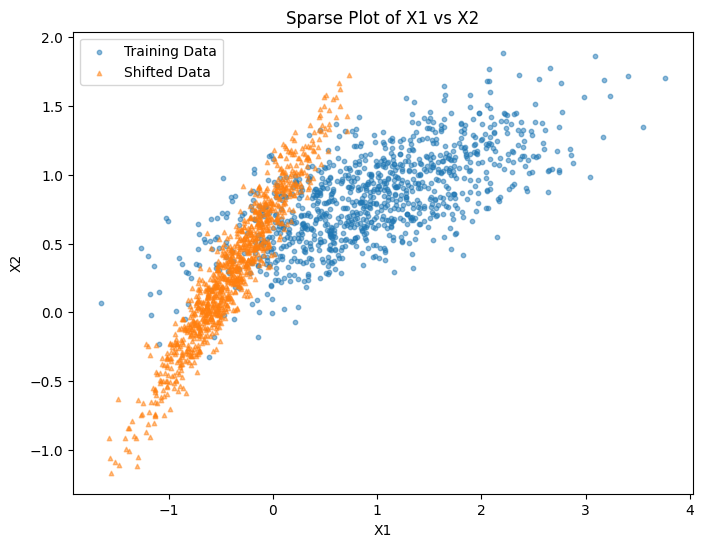

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(df_train['X1'], df_train['X2'], label='Training Data', alpha=0.5, s=10) # sparse plot for df_train
plt.scatter(df_shift['X1'], df_shift['X2'], label='Shifted Data', alpha=0.5, s=10, marker='^') # sparse plot for df_shift
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Sparse Plot of X1 vs X2')
plt.legend()
plt.show()

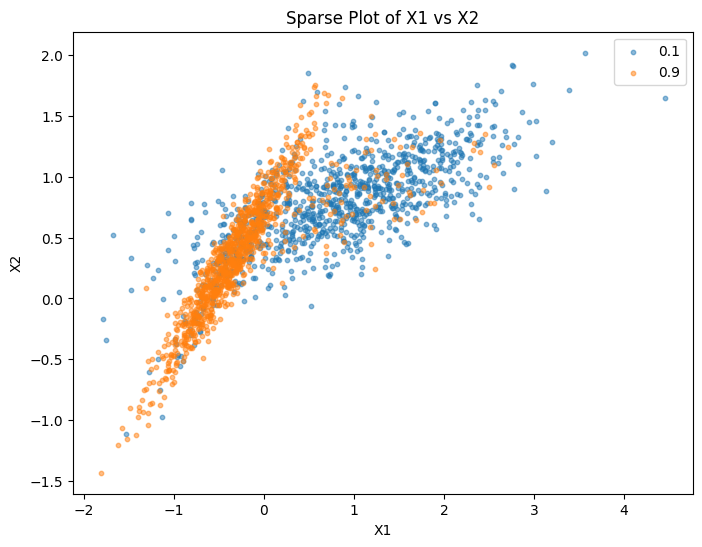

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(df_dict[0.1]['X1'], df_dict[0.1]['X2'], label='0.1', alpha=0.5, s=10) # sparse plot for df_train
plt.scatter(df_dict[0.9]['X1'], df_dict[0.9]['X2'], label='0.9', alpha=0.5, s=10) # sparse plot for df_train
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Sparse Plot of X1 vs X2')
plt.legend()
plt.show()

In [34]:
def hist_compare(df1, df2, attribute, kernel=True):
  sns.histplot(df1[attribute], kde = kernel) # kernel density estimation
  sns.histplot(df2[attribute], kde = kernel) # kernel density estimation
  plt.show()

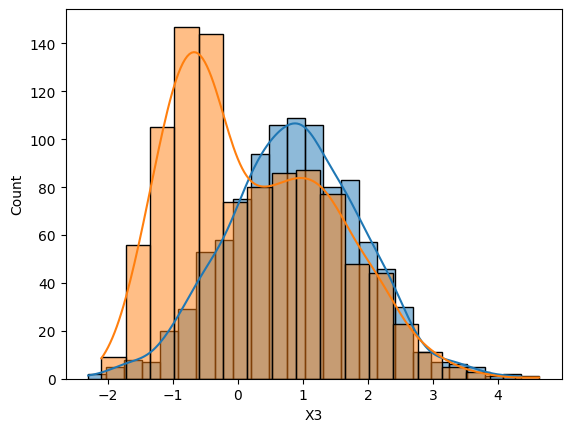

In [35]:
hist_compare(df_train, df_dict[0.4], 'X3')

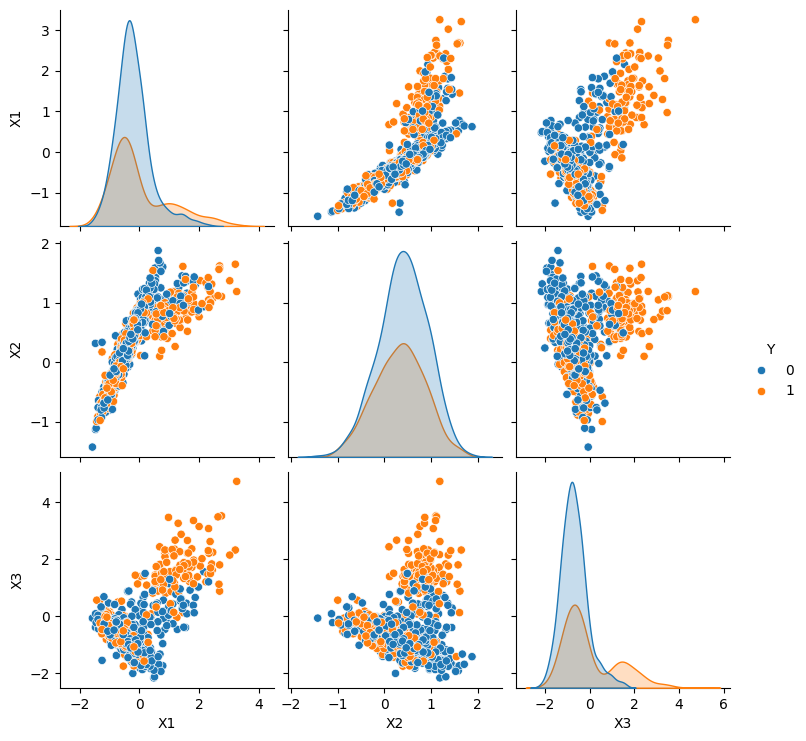

In [36]:
sns.pairplot(df_dict[0.8], vars=['X1', 'X2', 'X3'], hue='Y')
plt.show()

## Saving Data to Files

**Obs:** df_train is equivalent to df_mix[0.0] as well as df_shift is eq. to df_mix[1.0]

In [37]:
import os
#import shutil

# Create a folder in the previous directory
folder_name = os.path.join(os.path.pardir, 'data')
os.makedirs(folder_name, exist_ok=True)

# Save DataFrames to CSV files within the folder
df_train.to_csv(os.path.join(folder_name, 'train.csv'), index=False)
df_shift.to_csv(os.path.join(folder_name, 'shift.csv'), index=False)

for mix_prob, df in df_dict.items():
    df.to_csv(os.path.join(folder_name, f'mix_{mix_prob}.csv'), index=False)

Saving the all the parameters used to generate the data into `Parameters.txt`

In [38]:
file_name = 'Parameters.txt'
file_path = os.path.join(folder_name, file_name)

with open(file_path, 'w') as f:
  f.write('Polinomial coefficients\n')
  f.write(f'{coef_train}\n')
  f.write('Mean train\n')
  f.write(f'{mean_train}\n')
  f.write('Covariance train\n')
  f.write(f'{covariance_train}\n')
  f.write('Mean shift\n')
  f.write(f'{mean_shift}\n')
  f.write('Covariance shift\n')
  f.write(f'{covariance_shift}\n')

## (Optional) Download all the files

If workig from Colab

In [15]:
# from google.colab import files
# import glob

# # Get all files within the 'data' directory
# all_files = glob.glob('data/*')

# # Download each file individually
# for file in all_files:
#   files.download(file)